# Beta Diversity Analysis, Rarefaction and Significance Tests

        

## 0. Set_up

In [54]:
import os
import pandas as pd
import qiime2 as q2
from skbio import OrdinationResults
from qiime2 import Visualization
import matplotlib.pyplot as plt
from seaborn import scatterplot

%matplotlib inline

In [34]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

In [3]:
data_dir ='project_data'

In [3]:
ls

A_FirstLook.ipynb                figures/
B_Eating_habits.ipynb            G_Beta_Diversity.ipynb
C_Sequence_import.ipynb          H_DifferentialAbundance.ipynb
D_Taxonomy_NCBI.ipynb            I_Metagenomics.ipynb
D_Taxonomy_pre-classifier.ipynb  J_Functional_Redoundancy_and_Stability.ipynb
D_Taxonomy_SILVA.ipynb           project_data/
E_Phylogeny.ipynb                Z_GanttChart.ipynb
F_Alpha_Diversity.ipynb


In order to run this code, you need results of functions done on previous file : 
- `metadata` gathering is done in file A
- `diversity computation` is done in file F

<a id='sec1'></a>

## 1. Import metadata

Metadata of refers to students additional informations we collected into the file "sample_meta_data.tsv".

In [14]:
df_meta = pd.read_csv(f'{data_dir}/sample_meta_data.tsv', sep='\t')

## 2.Compute diversity

Beta diversity measures the similarity between samples or groups of samples.        
To inspect groupings of beta diversity metrics across metadata categories, we will start by inspecting the principal coordinates (PCoA) plots created with the `qiime diversity core-metrics-phylogenetic` method in file F (directory core-metrics-results)

#### **Selection of categorical variables of interest**

In [23]:
df_cat = df_meta.select_dtypes(include=['object'])
df_cat.describe()

,GEN_age_cat,GEN_bmi_cat,GEN_collection_timestamp,GEN_country,GEN_geo_loc_name,GEN_host_common_name,GEN_last_move,GEN_last_travel,GEN_level_of_education,GEN_race,...,NUT_probiotic_frequency,NUT_red_meat_frequency,NUT_salted_snacks_frequency,NUT_seafood_frequency,NUT_sugary_sweets_frequency,NUT_vegetable_frequency,NUT_vitamin_b_supplement_frequency,NUT_vitamin_d_supplement_frequency,NUT_whole_eggs,NUT_whole_grain_frequency
count,523,523,523,523,523,523,523,523,523,523,...,523,523,523,523,523,523,523,523,523,523
unique,9,5,505,17,62,1,6,6,8,6,...,6,6,6,6,6,6,6,6,6,6
top,50s,Normal,2016-08-01 08:00:00,United Kingdom,United Kingdom:England,human,I have lived in my current state of residence ...,I have not been outside of my country of resid...,Graduate or Professional degree,Caucasian,...,Never,Occasionally,Rarely,Occasionally,Rarely,Daily,Never,Never,Occasionally,Regularly
freq,121,274,5,255,169,523,475,168,232,474,...,216,200,198,232,150,260,328,268,215,147


In [26]:
for col in df_cat.columns:
    print(col)

GEN_age_cat
GEN_bmi_cat
GEN_collection_timestamp
GEN_country
GEN_geo_loc_name
GEN_host_common_name
GEN_last_move
GEN_last_travel
GEN_level_of_education
GEN_race
GEN_sample_type
GEN_sex
NUT_alcohol_frequency
NUT_artificial_sweeteners
NUT_diet_type
NUT_drinks_per_session
NUT_fed_as_infant
NUT_fermented_plant_frequency
NUT_frozen_dessert_frequency
NUT_fruit_frequency
NUT_gluten
NUT_high_fat_red_meat_frequency
NUT_homecooked_meals_frequency
NUT_meat_eggs_frequency
NUT_milk_cheese_frequency
NUT_milk_substitute_frequency
NUT_olive_oil
NUT_poultry_frequency
NUT_prepared_meals_frequency
NUT_probiotic_frequency
NUT_red_meat_frequency
NUT_salted_snacks_frequency
NUT_seafood_frequency
NUT_sugary_sweets_frequency
NUT_vegetable_frequency
NUT_vitamin_b_supplement_frequency
NUT_vitamin_d_supplement_frequency
NUT_whole_eggs
NUT_whole_grain_frequency


In [8]:
md = q2.Metadata.load(data_dir + '/sample_meta_data.tsv').to_dataframe()
pd.DataFrame([str(sorted(md[col].astype(str).unique())) for col in md.columns],
             index=pd.Index(md.columns, name='Column'), columns=['Values'])

,Values
Column,
GEN_age_cat,"['20s', '30s', '40s', '50s', '60s', '70+', 'No..."
GEN_age_corrected,"['11.0', '14.0', '15.0', '16.0', '17.0', '18.0..."
GEN_bmi_cat,"['Normal', 'Not provided', 'Obese', 'Overweigh..."
GEN_bmi_corrected,"['11.2', '11.57', '14.34', '14.62', '14.79', '..."
GEN_cat,"['False', 'True']"
GEN_collection_timestamp,"['2014-05-10 12:00:00', '2015-01-01 09:00:00',..."
GEN_country,"['Australia', 'Belgium', 'Canada', 'Georgia', ..."
GEN_dog,"['False', 'True']"
GEN_elevation,"['-0.9', '0.0', '1.4', '10.4', '10.8', '10.9',..."


Almost all the variables present in the dataframe df_cat can be interesting to test for beta-analysis. However, for the purpose of our research goals here, we will focus on data about age, BMI, country, level of education

#### **Permanova testing of categorical variables associations**

Associations between beta diversity and categorical variables can be statistically tested using a PERMANOVA test. This is a non-parametric statistical test that checks the null hypothesis that the distances between samples of one group are equivalent to distances to samples of another group. If this null hypothesis is rejected, we can infer that the distances between samples of one group differ significantly from the distances to samples in at least one other group. We can perform a PERMANOVA test checking whether the observed categories are significantly grouped in QIIME 2 with the `qiime diversity beta-group-significance` method: 

In [40]:
os.mkdir('/home/jovyan/HealthyFood/JupyterDocs/project_data/core-metrics-results-bd')

**Testing differences between samples according to bmi = unsignificant**

**Testing differences between samples according to age = significant**

In [101]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --m-metadata-column GEN_host_common_name\
--p-pairwise\
--o-visualization $data_dir/core-metrics-results-bd/bc-hcn-significance.qzv

Plugin error from diversity:

  All values in the grouping vector are the same. This method cannot operate on a grouping vector with only a single group of objects (e.g., there are no 'between' distances because there is only a single group).

Debug info has been saved to /tmp/qiime2-q2cli-err-oztv_vrd.log


In [4]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/wu_oo-significance.qzv')

<visualization: Visualization uuid: 5864dd79-db7c-4326-a4ad-ebc478fbd5fe>

In [124]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --m-metadata-column NUT_prepared_meals_frequency \
--p-pairwise \
--o-visualization $data_dir/core-metrics-results-bd/wu_pmf-significance.qzv

Saved Visualization to: project_data/core-metrics-results-bd/wu_pmf-significance.qzv


In [125]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/wu_pmf-significance.qzv')

<visualization: Visualization uuid: c4d03365-0fd8-4fcc-a12b-be094d273ebb>

In [111]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --m-metadata-column GEN_race\
--p-pairwise \
--o-visualization $data_dir/core-metrics-results-bd/wu_race-significance.qzv

Saved Visualization to: project_data/core-metrics-results-bd/wu_race-significance.qzv


In [112]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/wu_race-significance.qzv')

<visualization: Visualization uuid: c9fbc42a-525f-40e4-a969-8128ba6f9f7b>

**Testing differences between samples according to race = significant**

In [60]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --m-metadata-column GEN_race \
--p-pairwise\
--o-visualization $data_dir/core-metrics-results-bd/bc-race-significance.qzv

Saved Visualization to: project_data/core-metrics-results-bd/bc-race-significance.qzv


In [4]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/bc-race-significance.qzv')

<visualization: Visualization uuid: 3c74f105-f319-46ee-86a0-b63176dff570>

**Testing differences between samples according to level of education = unsignificant**

In [62]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --m-metadata-column GEN_level_of_education \
--p-pairwise\
--o-visualization $data_dir/core-metrics-results-bd/bc-loe-significance.qzv

Saved Visualization to: project_data/core-metrics-results-bd/bc-loe-significance.qzv


In [63]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/bc-loe-significance.qzv')

<visualization: Visualization uuid: 0c1e7e19-bb79-42e5-9de9-3d75962fd9f8>

#### **Adonis implementation pf PERMANOVA tests**

The `adonis` implementation of PERMANOVA (part of the r-vegan package) accepts a formula as input, which can consist of one or more independent terms. This might be useful for testing which covariates explain the most variation in our datasets.

In [71]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "GEN_bmi_cat*GEN_age_cat*GEN_race*GEN_level_of_education" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-bc-bmiageraceloe.qzv

Saved Visualization to: project_data/core-metrics-results-bd/adonis-bc-bmiageraceloe.qzv


<a id='sec3'></a>

In [3]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-bc-bmiageraceloe.qzv')

<visualization: Visualization uuid: a49cf481-65b6-446f-9dee-7da0d9ead84c>

Reste à faire : génèrer automatiquement la liste des catégories que l'on pense d'intérêt (voir avec les filles si elles veulent garder toutes les catégories mais proposer avant), comme ça on fait qu'un seul test adonis pour tout et on screen juste ce qui ets inférieur à 0.05 et on aura rien oublié

In [4]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_alcohol_frequency*NUT_artificial_sweeteners*NUT_diet_type*NUT_drinks_per_session*NUT_fed_as_infant*NUT_fermented_plant_frequency*NUT_frozen_dessert_frequency*NUT_fruit_frequency*NUT_gluten*NUT_high_fat_red_meat_frequency*NUT_homecooked_meals_frequency*NUT_meat_eggs_frequency*NUT_milk_cheese_frequency*NUT_milk_substitute_frequency*NUT_olive_oil*NUT_poultry_frequency*NUT_prepared_meals_frequency*NUT_probiotic_frequency*NUT_red_meat_frequency*NUT_salted_snacks_frequency*NUT_seafood_frequency*NUT_sugary_sweets_frequency*NUT_vegetable_frequency*NUT_vitamin_b_supplement_frequency*NUT_vitamin_d_supplement_frequency*NUT_whole_eggs*NUT_whole_grain_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-bc-todo.qzv

In [5]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-bc-todo.qzv')

ValueError: project_data/core-metrics-results-bd/adonis-bc-todo.qzv does not exist.

### Hypothesis 1 : alcool

In [7]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_alcohol_frequency*NUT_alcohol_consumption" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wuc-H1alcool.qzv

Saved Visualization to: project_data/core-metrics-results-bd/adonis-wuc-H1alcooldiet.qzv


In [9]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wuc-H1alcool.qzv')

<visualization: Visualization uuid: 6d6399e1-bcfd-4451-b1ec-3e32c56d7f65>

### Hypothesis 2 : Milk products

In [10]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_milk_cheese_frequency*NUT_milk_substitute_frequency*NUT_vitamin_d_supplement_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wu-H2milkp.qzv

Saved Visualization to: project_data/core-metrics-results-bd/adonis-wu-H2milkp.qzv


In [11]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wu-H2milkp.qzv')

<visualization: Visualization uuid: 89def620-4fc3-4cfc-bea1-83454f0a062b>

### Hypothesis 3 : Mediterranean diet

In [14]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_olive_oil*NUT_seafood_frequency*NUT_vegetable_frequency*NUT_fruit_frequency*NUT_whole_grain_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wu-H3med.qzv

Saved Visualization to: project_data/core-metrics-results-bd/adonis-wu-H3med.qzv


In [15]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wu-H3med.qzv')

<visualization: Visualization uuid: 986c91c6-9e8f-4e37-a855-10334dbbd341>

### Hypothesis 4 : Poultry

In [16]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_whole_eggs*NUT_poultry_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wu-H4poultry.qzv

Saved Visualization to: project_data/core-metrics-results-bd/adonis-wu-H4poultry.qzv


In [17]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wu-H4poultry.qzv')

<visualization: Visualization uuid: 9bd3aa61-bc6c-48ee-8611-3bd5f7f8c020>

### Hypothesis 5 : Meat

In [18]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_high_fat_red_meat_frequency*NUT_meat_eggs_frequency*NUT_red_meat_frequency*NUT_vitamin_b_supplement_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wu-H5meat.qzv

Saved Visualization to: project_data/core-metrics-results-bd/adonis-wu-H5meat.qzv


In [19]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wu-H5meat.qzv')

<visualization: Visualization uuid: 0800b8be-067f-42b0-926f-a8c3893db6c8>

### Hypothesis 6 : Drink 

In [20]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_alcohol_frequency*NUT_drinks_per_session" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wu-H6drink.qzv

Saved Visualization to: project_data/core-metrics-results-bd/adonis-wu-H6drink.qzv


In [22]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wu-H6drink.qzv')

<visualization: Visualization uuid: 6e2b3e78-8648-48f2-b25e-31ff111ef804>

# Figures 

In [21]:
pcs = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results/weighted_unifrac_pcoa_results.qza'))
pcs = pcs.view(OrdinationResults)
pcs_data = pcs.samples.iloc[:,:3]
pcs_data.columns = ['Axis 1', 'Axis 2', 'Axis 3']

In [17]:
pcs_data.head()

,Axis 1,Axis 2,Axis 3
10317.000002929,-0.144197,-0.023014,0.022661
10317.000002930,-0.139421,-0.016882,0.178423
10317.000003283,0.026313,0.051591,0.002213
10317.000004079,-0.150133,0.030451,-0.045630
10317.000016169,-0.069590,0.008753,-0.035616


In [52]:
pcs_data_with_md = pcs_data.join(md['GEN_age_cat'])

<AxesSubplot:xlabel='Axis 1', ylabel='Axis 2'>

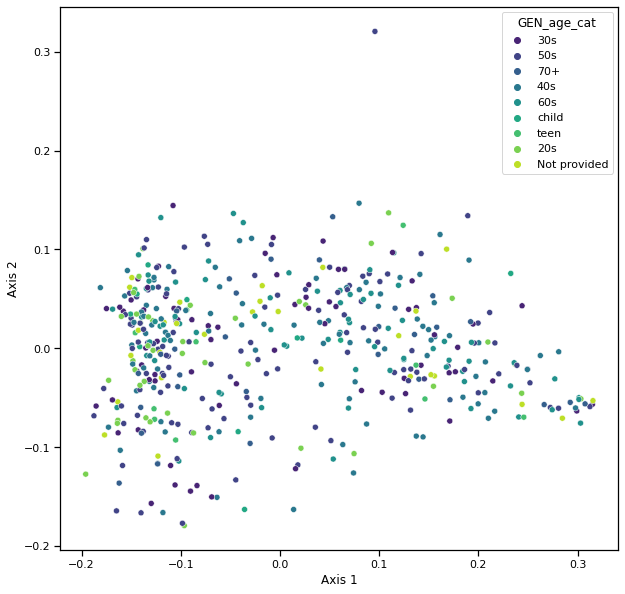

In [53]:
scatterplot(data=pcs_data_with_md,
x='Axis 1',
y='Axis 2',
hue='GEN_age_cat', 
palette='viridis')


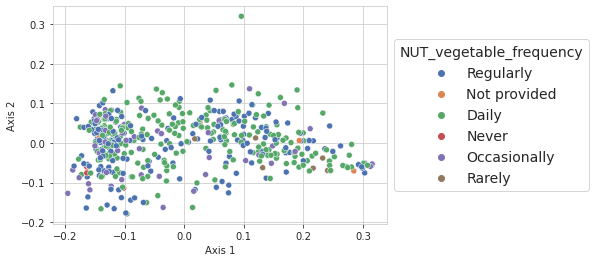

In [40]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots()
    sns.set(rc={'figure.figsize':(10,10)}, style='white')
    sns.scatterplot(data=pcs_data_with_md, x='Axis 1', y='Axis 2', ax=ax, hue=pcs_data_with_md['NUT_vegetable_frequency'])
        
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, title_fontsize=14)
    legend = ax.get_legend()
    legend.set_title('NUT_vegetable_frequency')
    

    ax.tick_params(axis='x', which='major', bottom=True) 
    ax.tick_params(axis='y', which='major', left=True)